# Collaboration and Competition

---

In this notebook, we solve the collaborative, multi-agent Tennis environemnt. For a description of the environment, see the [Readme file in this repository](README.md).

# Algorithm

The algorithm used is the famous [Multi Agent Deep Deterministic Policy Gradients](https://papers.nips.cc/paper/7217-multi-agent-actor-critic-for-mixed-cooperative-competitive-environments.pdf). The basic idea of this algorithm is to model each agent in the environemnt as Deep Deterministic Policy Gradient, but to share some information between agents. 

Specifically, each agent has its **own** actor and critic model. The actor network receives the individual observations, the critic, however, receives the combined information of all agents. 

# Network and hyperparameters

Each network (i.e. actor and critic) consists of two fully connected layers with 256 hidden units in each layer. The activation functions are relatively standard as well, namely Relu. A batch normalization layer was introduced after the first layer.

The learning rates were chosen as 0.0001 for the actor and 0.001 for the critic, batch size was 256. Some other values were tried, but making the learning rates higher led to convergence problems and did not speed the training up. As optimizer, Adam was chosen.  The exploratory noise was kept constant for a total of 30'000 steps and then turned off. The replay buffer had a size of 10'000.

# Training loop

In the following chunks, we perform the training.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

from agent import MADDPG
import torch
from collections import deque
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

In [2]:
env = UnityEnvironment(file_name="Tennis", no_graphics=False)
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
agent = MADDPG(seed=666, noise_start=0.5, update_every=2, gamma=1, t_stop_noise=3000000)
n_episodes = 6000
max_t = 1000
scores = []
scores_deque = deque(maxlen=100)
scores_avg = []

for i_episode in range(1, n_episodes+1):
    rewards = []
    env_info = env.reset(train_mode=False)[brain_name]    # reset the environment    
    state = env_info.vector_observations                  # get the current state (for each agent)

    # loop over steps
    for t in range(max_t):
        # select an action
        action = agent.act(state)
        # take action in environment and set parameters to new values
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        rewards_vec = env_info.rewards
        done = env_info.local_done
        # update and train agent with returned information
        agent.step(state, action, rewards_vec, next_state, done)
        state = next_state
        rewards.append(rewards_vec)
        if any(done):
            break

    # calculate episode reward as maximum of individually collected rewards of agents
    episode_reward = np.max(np.sum(np.array(rewards),axis=0))
        
    scores.append(episode_reward)             # save most recent score to overall score array
    scores_deque.append(episode_reward)       # save most recent score to running window of 100 last scores
    current_avg_score = np.mean(scores_deque)
    scores_avg.append(current_avg_score)      # save average of last 100 scores to average score array
    
    print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score),end="")
    
    # log average score every 200 episodes
    if i_episode % 200 == 0:
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score))
        agent.save_agents()

    # break and report success if environment is solved
    if np.mean(scores_deque)>=.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        agent.save_agents()
        break

Episode 200	Average Score: 0.001
Episode 400	Average Score: 0.000
Episode 600	Average Score: 0.008
Episode 800	Average Score: 0.028
Episode 1000	Average Score: 0.010
Episode 1200	Average Score: 0.011
Episode 1400	Average Score: 0.062
Episode 1600	Average Score: 0.040
Episode 1800	Average Score: 0.087
Episode 2000	Average Score: 0.194
Episode 2200	Average Score: 0.431
Episode 2208	Average Score: 0.514
Environment solved in 2208 episodes!	Average Score: 0.514


We see that the agents take a relatively long time to make progress. Then the progress is also not always clearly positive. Eventually, the environment is solved after around 3'200 episodes.

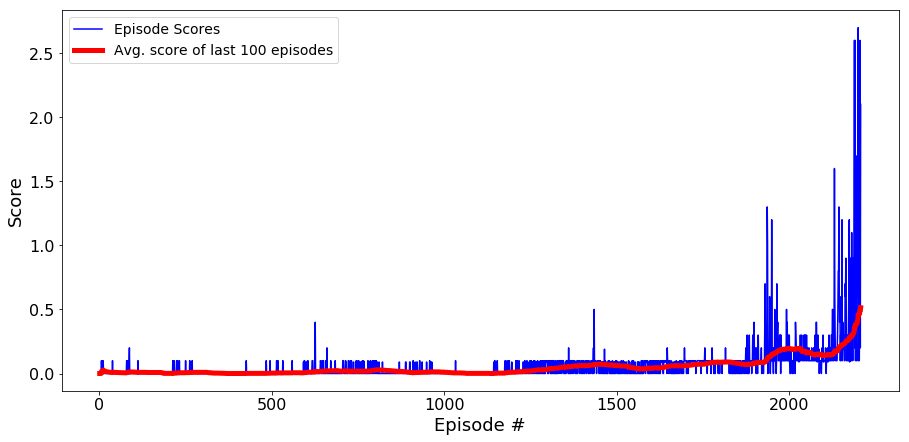

In [4]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,'b',label='Episode Scores')
plt.plot(np.arange(1, len(scores)+1), scores_avg,'r',\
         linewidth=5,label='Avg. score of last 100 episodes')
plt.ylabel('Score', fontsize=18)
plt.xlabel('Episode #', fontsize=18)
ax.legend(fontsize=14)
plt.show()

In [11]:
env.close()

# Future directions

An obvious future direction is to play around more with the hyperparamters to make the learning faster.

Another promising direction is to try other algorithms, for example [Proximal Policy Optimization (PPO)](https://arxiv.org/abs/1707.06347). 